In [4]:
import torch
import torch.nn as nn
import numpy as np
import random
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

class PixelBlendMix(nn.Module):
    def __init__(self,  ratios=(0.0, 1.0), resize_method="LANCZOS", random_seed=None):
        super().__init__()
        self.ratios = ratios
        self.random_seed = random_seed
        
        resize_map = {
            "LANCZOS": InterpolationMode.LANCZOS,
            "BILINEAR": InterpolationMode.BILINEAR,
            "BICUBIC": InterpolationMode.BICUBIC,
            "NEAREST": InterpolationMode.NEAREST,
            "BOX": InterpolationMode.BOX,
            "HAMMING": InterpolationMode.HAMMING,
        }
        self.resize_method = resize_map.get(resize_method.upper(), InterpolationMode.LANCZOS)

    def forward(self, real_img,fake_img):
        if self.random_seed is not None:
            random.seed(self.random_seed)
            np.random.seed(self.random_seed)

        
        if isinstance(real_img, torch.Tensor):
            if isinstance(fake_img, Image.Image):
                fake_img = F.to_tensor(fake_img).to(real_img.device)
            
            if real_img.shape[-2:] != fake_img.shape[-2:]:
                fake_img = F.resize(fake_img, real_img.shape[-2:], self.resize_method)

            blend_factor = random.uniform(self.ratios[0], self.ratios[1])
            return torch.lerp(real_img, fake_img, blend_factor)

        else:
            if real_img.mode != "RGB":
                real_img = real_img.convert("RGB")
                
            if real_img.size != fake_img.size:
                fake_img = F.resize(fake_img, (real_img.size[1], real_img.size[0]), self.resize_method)

            real_arr = np.array(real_img).astype(np.float32)
            fake_arr = np.array(fake_img).astype(np.float32)

            blend_factor = random.uniform(self.ratios[0], self.ratios[1])
            blended = blend_factor * fake_arr + (1 - blend_factor) * real_arr
            
            return Image.fromarray(np.clip(blended, 0, 255).astype(np.uint8))

In [14]:
import matplotlib.pyplot as plt
def plot_comparisons(real, recon, mixed):
    """
    Plots two rows:
    1. Real vs Recon (and Residual)
    2. Real vs Mixed (and Residual)
    """
    real_np = np.array(real).astype(np.float32)
    recon_np = np.array(recon).astype(np.float32)
    mixed_np = np.array(mixed).astype(np.float32)

    # Calculate Residuals (Mean across RGB channels)
    resid_recon = np.mean(np.abs(real_np - recon_np), axis=2)
    resid_mixed = np.mean(np.abs(real_np - mixed_np), axis=2)

    # Common scale for heatmap comparison
    # We use 99th percentile of the recon error as the max scale for both
    vmax = np.percentile(resid_recon, 99)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # --- ROW 1: Recon vs Real ---
    axes[0, 0].imshow(real)
    axes[0, 0].set_title("Original (Real)")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(recon)
    axes[0, 1].set_title("VAE Reconstruction")
    axes[0, 1].axis("off")

    im1 = axes[0, 2].imshow(resid_recon, cmap='inferno', vmin=0, vmax=vmax)
    axes[0, 2].set_title(f"Residual: |Real - Recon|\n(Mean Err: {np.mean(resid_recon):.2f})")
    axes[0, 2].axis("off")
    fig.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # --- ROW 2: Mixed vs Real ---
    axes[1, 0].imshow(real)
    axes[1, 0].set_title("Original (Real)")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(mixed)
    axes[1, 1].set_title("pixel Mixed ")
    axes[1, 1].axis("off")

    im2 = axes[1, 2].imshow(resid_mixed, cmap='inferno', vmin=0, vmax=vmax)
    axes[1, 2].set_title(f"Residual: |Real - Mixed|\n(Mean Err: {np.mean(resid_mixed):.2f})")
    axes[1, 2].axis("off")
    fig.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [5]:
pixel_blender = PixelBlendMix()

In [10]:
real_pil = Image.open("../src/real.png")
recon_pil = Image.open("../src/recon.png")
result_pil = pixel_blender(real_img,fake_img)

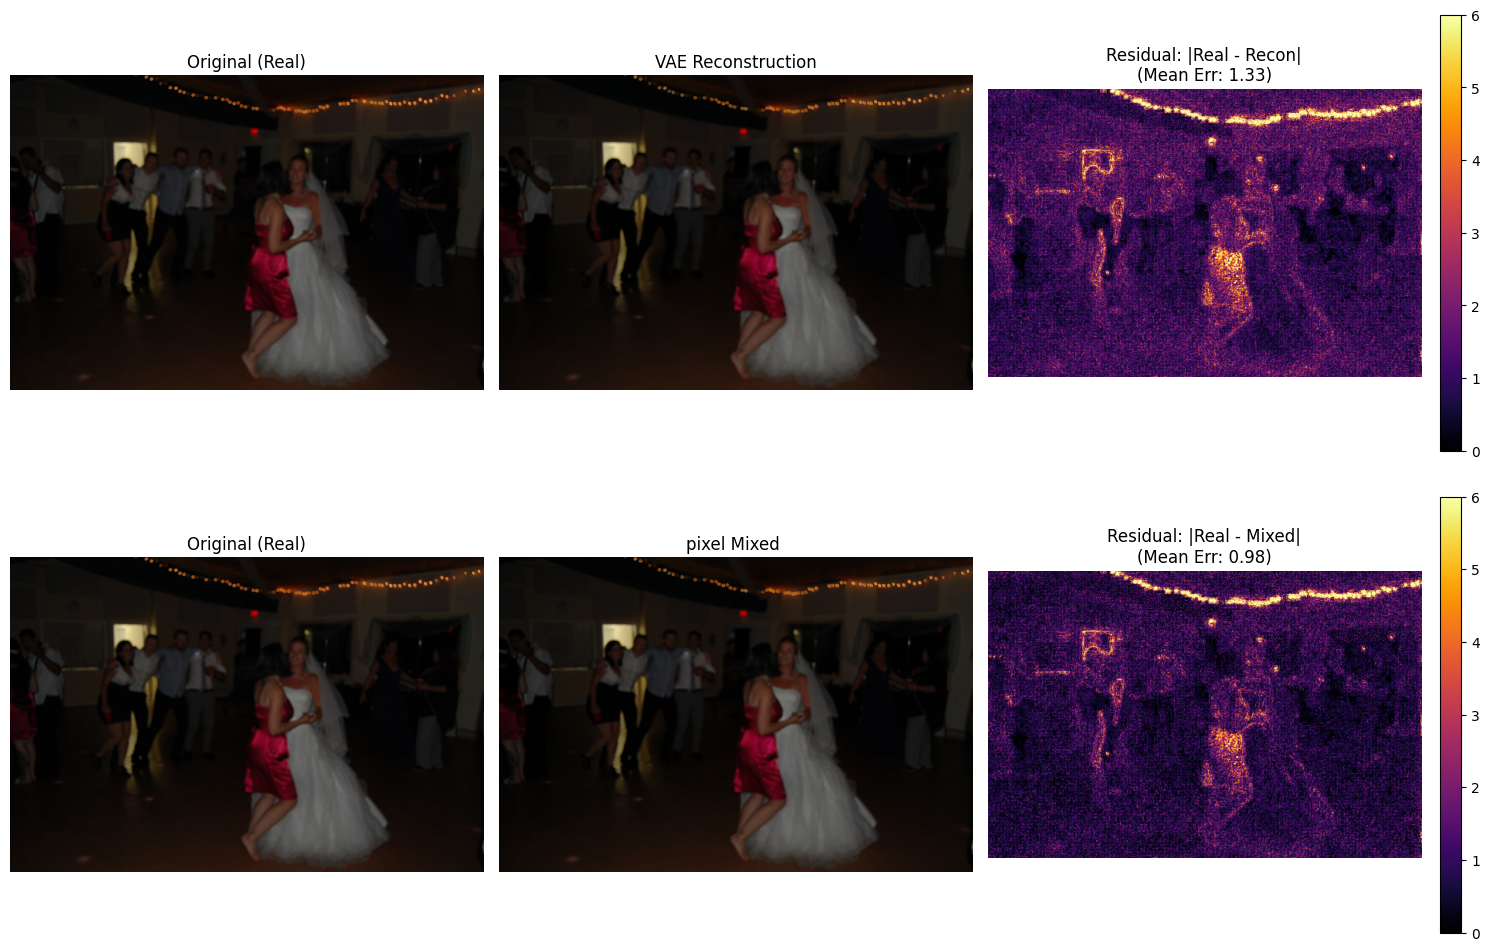

In [15]:
plot_comparisons(real_pil,recon_pil,result_pil)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft2, fftshift

def calc_and_plot_freq_error(real_img, fake_img, save_plot_path=None):
    """
    Calculates relative frequency error (Low vs High band) between a Real and Fake image
    and plots a Bar Chart.

    """

    # 1. Load Images
    try:
        real_img = real_img.convert("L") # Convert to Grayscale for DFT
        size = real_img.size
        fake_img = fake_img.convert("L")
    except FileNotFoundError as e:
        print(f"Error loading images: {e}")
        return

    # Resize fake to match real if necessary
    if real_img.size != fake_img.size:
        fake_img = fake_img.resize(real_img.size, Image.LANCZOS)

    # 2. Prepare Data (Numpy)
    real_np = np.array(real_img).astype(np.float32)
    fake_np = np.array(fake_img).astype(np.float32)

    rows, cols = real_np.shape
    crow, ccol = rows // 2, cols // 2

    # 3. Compute DFT (Discrete Fourier Transform)
    # fft2: 2D FFT, fftshift: Center low frequencies
    fft_real = fftshift(fft2(real_np))
    fft_fake = fftshift(fft2(fake_np))

    # Calculate Magnitude Spectrum
    mag_real = np.abs(fft_real)
    mag_fake = np.abs(fft_fake)

    # Calculate Magnitude Difference (Absolute Error)
    diff_mag = np.abs(mag_real - mag_fake)

    # 4. Define Bands (Low vs High)
    # We define "Low Frequency" as the inner 15% radius of the spectrum
    radius = min(rows, cols) * 0.15
    y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    mask = x*x + y*y <= radius*radius  # True for Low Freq, False for High Freq

    # 5. Calculate Relative Errors
    # Error = Sum(Difference) / Sum(Base Magnitude)
    # Added 1e-8 to avoid division by zero

    low_freq_err = np.sum(diff_mag * mask) / (np.sum(mag_real * mask) + 1e-8)
    high_freq_err = np.sum(diff_mag * (~mask)) / (np.sum(mag_real * (~mask)) + 1e-8)

    print(f"--- Frequency Error Analysis ---")
    print(f"Low Frequency Error:  {low_freq_err:.4f}")
    print(f"High Frequency Error: {high_freq_err:.4f}")

    # 6. Plot Bar Chart
    labels = ['Low Frequency\n(Structure)', 'High Frequency\n(Edges/Noise)']
    values = [low_freq_err, high_freq_err]
    colors = ['#4CAF50', '#FF5722'] # Green for Low, Orange for High

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=colors, width=0.5, edgecolor='black', alpha=0.8)

    plt.ylabel('Relative Error Magnitude (Normalized)')
    plt.title(f'Frequency Domain Error Analysis\nReal vs fake ')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()

    if save_plot_path:
        plt.savefig(save_plot_path)
        print(f"Bar chart saved to {save_plot_path}")

    plt.show()


--- Frequency Error Analysis ---
Low Frequency Error:  0.0639
High Frequency Error: 0.4417


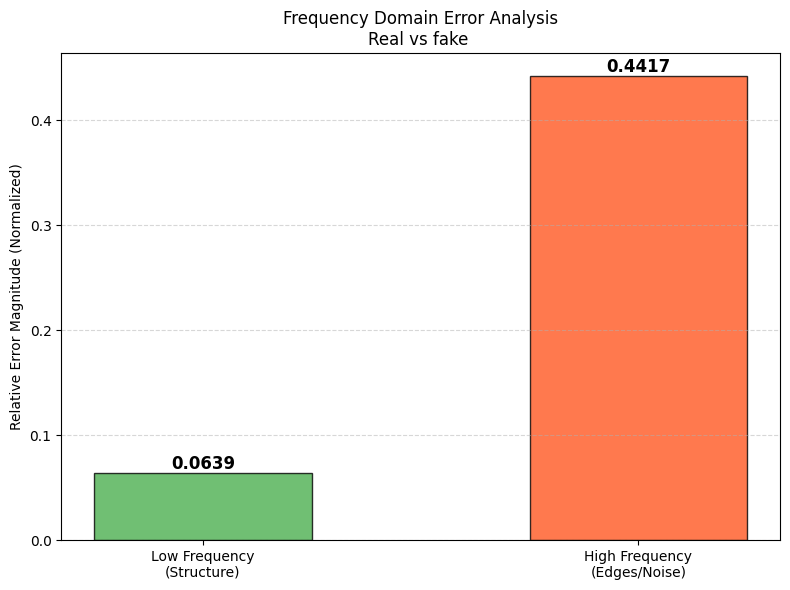

In [17]:
calc_and_plot_freq_error(real_pil,recon_pil)

--- Frequency Error Analysis ---
Low Frequency Error:  0.0532
High Frequency Error: 0.3877


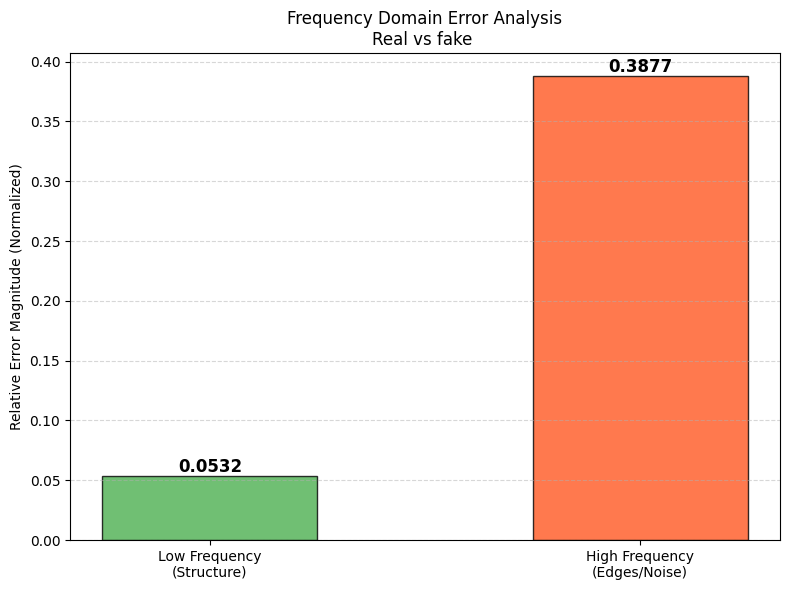

In [18]:
calc_and_plot_freq_error(real_pil,result_pil)
